In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf



In [38]:
# Importing matplotlib and creating helper func to plot graphs
import matplotlib.pyplot as plt

def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], "")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Set up input pipeline

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                         as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\HARDIK\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteEWQ52Q\imdb_reviews-trai…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\HARDIK\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteEWQ52Q\imdb_reviews-test…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\HARDIK\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteEWQ52Q\imdb_reviews-unsu…

Dataset imdb_reviews downloaded and prepared to C:\Users\HARDIK\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Returns example and labels let's examine it

In [10]:
for example, label in train_dataset.take(1):
    print('text', example.numpy())
    print('label', label.numpy())

text b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label 0


In [12]:
# Shuffle data for training
buffer_size = 10000
batch_size = 64

In [13]:
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
for example, label in train_dataset.take(1):
    print('text', example.numpy()[:3])
    print()
    print('label', label.numpy()[:3])

text [b'The deceptive cover, title and very small hidden print of Power of Prayer tricked me into renting this movie.<br /><br />It started out really well and pulled me in. I REALLY liked it. Between 1/3 and 3/4\'s of it, the film started throwing in things that were not set up and made no sense. My first thought was, "This is not written by someone who knows how to tell a story." I ended up re-watching parts of the movie, thinking I had missed something.<br /><br />By the time I reached the last 1/5 of the movie, it was all BORING, ANNOYING, RELIGION THUMPING DIALOG that made no sense, said nothing, and was annoying to listen to; I turned off the sound and did a fast forward to the end.<br /><br />Don\'t waste your time with this flick.<br /><br />Beware of DVDs labeled Whitlow Films and Level Path Productions.<br /><br />And I\'m a practicing Catholic.'
 b'No doubt intended as a totally campy joke, "Full Moon High" portrays 1950s teenager Tony Walker (Adam Arkin) accompanying his fa

### Create a text encoder 

In [16]:
vocab_size = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [17]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,   1, ...,   0,   0,   0],
       [ 57, 799,   1, ...,   0,   0,   0],
       [  2,   1, 114, ...,   0,   0,   0]], dtype=int64)

In [21]:
# the default setting in textencoder lead to some missing tokens results in [UNK]

for i in range(3):
    print("Original:", example[i].numpy())
    print()
    print("Round-trip:", " ".join(vocab[encoded_example[i]]))
    print()

Original: b'The deceptive cover, title and very small hidden print of Power of Prayer tricked me into renting this movie.<br /><br />It started out really well and pulled me in. I REALLY liked it. Between 1/3 and 3/4\'s of it, the film started throwing in things that were not set up and made no sense. My first thought was, "This is not written by someone who knows how to tell a story." I ended up re-watching parts of the movie, thinking I had missed something.<br /><br />By the time I reached the last 1/5 of the movie, it was all BORING, ANNOYING, RELIGION THUMPING DIALOG that made no sense, said nothing, and was annoying to listen to; I turned off the sound and did a fast forward to the end.<br /><br />Don\'t waste your time with this flick.<br /><br />Beware of DVDs labeled Whitlow Films and Level Path Productions.<br /><br />And I\'m a practicing Catholic.'

Round-trip: the [UNK] [UNK] title and very small [UNK] [UNK] of power of [UNK] [UNK] me into [UNK] this moviebr br it started 

# Model

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()),
    output_dim=64,
    mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

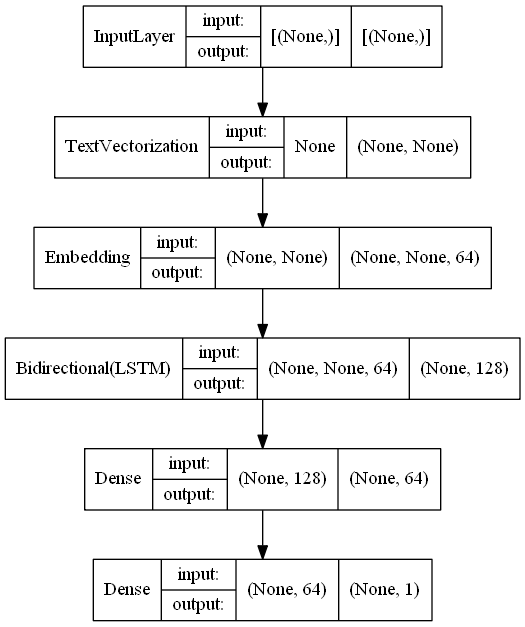

In [31]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

In [32]:
model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

## Training Model

In [33]:
history = model.fit(
            train_dataset,epochs=10,
            validation_data=test_dataset,
            validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1469s 4s/step - loss: 0.6433 - accuracy: 0.5671 - val_loss: 0.5084 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 1716s 4s/step - loss: 0.4625 - accuracy: 0.7601 - val_loss: 0.4320 - val_accuracy: 0.7927
Epoch 3/10
391/391 [==============================] - 795s 2s/step - loss: 0.3690 - accuracy: 0.8397 - val_loss: 0.3558 - val_accuracy: 0.8432
Epoch 4/10
391/391 [==============================] - 829s 2s/step - loss: 0.3357 - accuracy: 0.8545 - val_loss: 0.3341 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 805s 2s/step - loss: 0.3201 - accuracy: 0.8632 - val_loss: 0.3275 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 770s 2s/step - loss: 0.3104 - accuracy: 0.8676 - val_loss: 0.3250 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 754s 2s/step - loss: 0.3052 - accuracy: 0.8697 - val_loss: 0.3344 - val_accuracy: 0.84

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print('test loss: ', test_loss)
print('test acc: ', test_acc)

391/391 [==============================] - 118s 302ms/step - loss: 0.3229 - accuracy: 0.8627
test loss:  0.32293447852134705
test acc:  0.8627200126647949


(0.0, 0.6605164602398872)

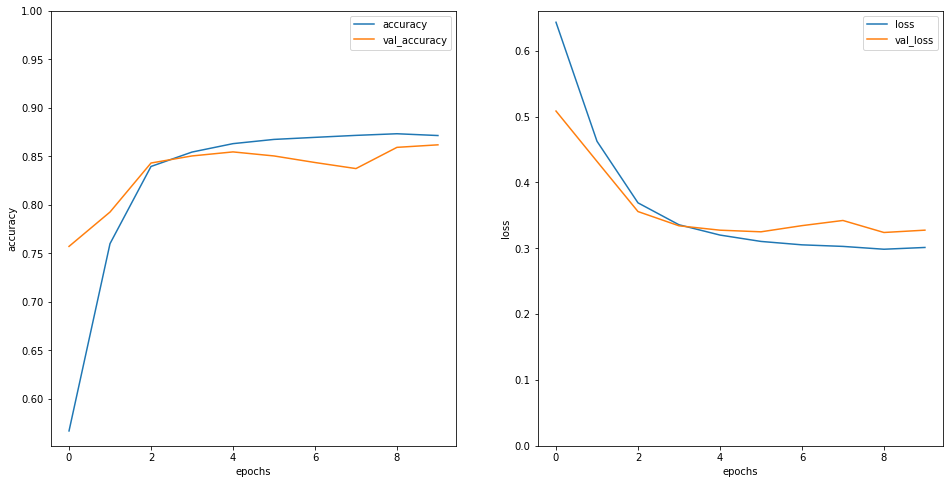

In [39]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graph(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [40]:
## Prediction
sample_text = ('This movie was cool. The animation and graphics were out of this world. I would recommend this movie')
prediction = model.predict(np.array([sample_text]))

In [41]:
print(prediction)

[[0.7715065]]


greater than 1 it means positive review

## Stacking two or more lstm layer with return sequence true

In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()),
    output_dim=64,
    mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

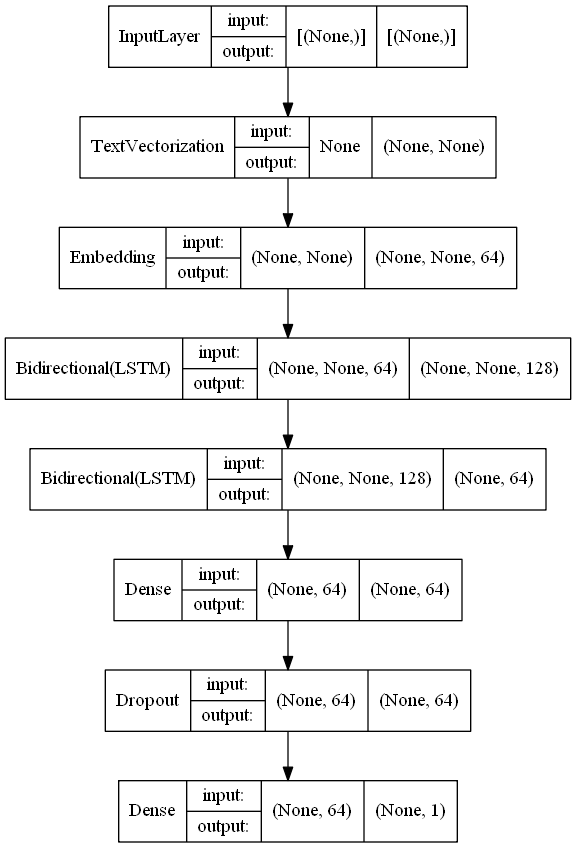

In [45]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

In [46]:
model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

In [47]:
history = model.fit(
            train_dataset,epochs=10,
            validation_data=test_dataset,
            validation_steps=30)

Epoch 1/10
391/391 [==============================] - 5031s 13s/step - loss: 0.6674 - accuracy: 0.5439 - val_loss: 0.5927 - val_accuracy: 0.7333
Epoch 2/10
391/391 [==============================] - 2324s 6s/step - loss: 0.4333 - accuracy: 0.8076 - val_loss: 0.4091 - val_accuracy: 0.7979
Epoch 3/10
391/391 [==============================] - 1734s 4s/step - loss: 0.3575 - accuracy: 0.8442 - val_loss: 0.3577 - val_accuracy: 0.8229
Epoch 4/10
391/391 [==============================] - 1275s 3s/step - loss: 0.3352 - accuracy: 0.8564 - val_loss: 0.3337 - val_accuracy: 0.8406
Epoch 5/10
391/391 [==============================] - 1288s 3s/step - loss: 0.3173 - accuracy: 0.8661 - val_loss: 0.3246 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 2405s 6s/step - loss: 0.3094 - accuracy: 0.8664 - val_loss: 0.3304 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 2548s 7s/step - loss: 0.3091 - accuracy: 0.8672 - val_loss: 0.3197 - val_accuracy

In [48]:
test_loss, test_acc = model.evaluate(test_dataset)

print('test loss: ', test_loss)
print('test acc: ', test_acc)

391/391 [==============================] - 679s 2s/step - loss: 0.3431 - accuracy: 0.8604
test loss:  0.34313446283340454
test acc:  0.8604400157928467


(0.0, 0.6859765544533729)

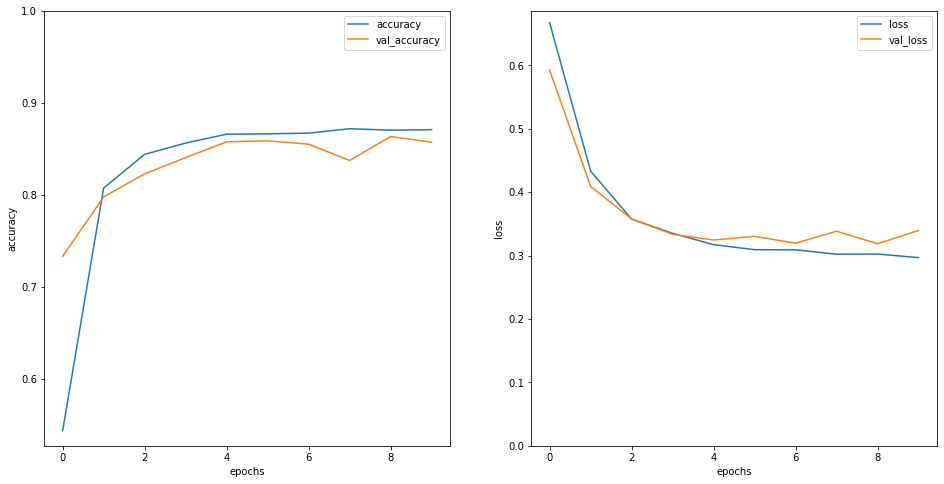

In [49]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graph(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [50]:
## Prediction
sample_text = ('This movie was cool. The animation and graphics were out of this world. I would recommend this movie')
prediction = model.predict(np.array([sample_text]))

In [51]:
print(prediction)

[[0.5539352]]


In [52]:
## Prediction
sample_text = ('This movie was boring. The animation and graphics were disappointing. I would not recommend this movie')
prediction = model.predict(np.array([sample_text]))

In [53]:
prediction

array([[-1.6738058]], dtype=float32)

In [54]:
sample_text = ("The plot was very simplistic, and if done the right way could have been handled nicely, but instead it was poorly executed. Part of the reasons why this film wasn't that good was the poor dialog, cheap laughs, choppy directing, and an awkward feeling that the film was somewhat incomplete.")

In [57]:
prediction = model.predict(np.array([sample_text]))

In [58]:
prediction

array([[-4.3453207]], dtype=float32)

Here negative value indicate that review is negaitve and positive value indicate that review is positive 